## Index
1. Libraries
2. Data Sets
3. Subsetting, wrangling, and cleaning time-series data
4. Time-series analysis: decomposition
5. Testing for stationarity
6. Stationarizing the data

## 01. Libraries

In [3]:
#Importing visualization and analytical libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import os
import warnings 

from pylab import rcParams # This will define a fixed size for all special charts.
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

## 02 Data Sets

In [5]:
#Creating path

path=r'/Users/konstant/Documents/Achievement 6 - Advanced Analytics and Dashboard design'

In [6]:
# Importing data set

df_prepared= pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'global_food_wastage_prepared.csv'), index_col = False)

In [7]:
df_prepared.head()

,Unnamed: 0,Country,Year,Food Category,Total Waste (Tons),Economic Loss (Million $),Avg Waste per Capita (Kg),Population (Million),Household Waste (%)
0,0,Argentina,2018,Bakery Items,72290.69,71749.94,60.3725,528.2025,59.035000
1,1,Argentina,2018,Beverages,127249.21,128791.57,131.8000,525.7825,37.177500
2,2,Argentina,2018,Dairy Products,28971.41,25935.06,94.5000,680.0200,54.286667
3,3,Argentina,2018,Frozen Food,78925.33,87757.40,123.7800,991.5350,62.292500
4,4,Argentina,2018,Grains & Cereals,152731.27,156398.00,122.7050,676.5950,53.573333


## 03. Subsetting, Wrangling and Cleaning Time-Series Data

In [9]:
df_prepared.shape

(1106, 9)

In [10]:
# Although the df is already aggregated to show 1 line per food category and Year, I need to further aggregate it to show 1 line per year
# and country. The food category can be excluded

aggregated_df = df_prepared.groupby(['Country', 'Year'], as_index=False).agg({
    'Total Waste (Tons)': 'sum',
    'Economic Loss (Million $)': 'sum',
    'Avg Waste per Capita (Kg)': 'mean',
    'Population (Million)': 'mean',
    'Household Waste (%)': 'mean'})

In [11]:
aggregated_df.shape

(140, 7)

In [12]:
# Create DataFrame with datetime index (end of each year)

df_yearly_waste = pd.DataFrame(aggregated_df)
df_yearly_waste['Year'] = pd.to_datetime(df_yearly_waste['Year'], format='%Y')
df_yearly_waste.set_index('Year', inplace=True)

In [13]:
# Convert annual to monthly by forward-filling, then distributing values

monthly_index = pd.date_range(start='2018-01-01', end='2024-12-31', freq='M')
monthly_df = pd.DataFrame(index=monthly_index)

In [14]:
# Add a 'Year' column to map each month to the corresponding year

monthly_df['Year'] = monthly_df.index.year
monthly_df['Year'] = pd.to_datetime(monthly_df['Year'], format='%Y')

In [15]:
# Join annual waste data to monthly, based on year

monthly_df = monthly_df.join(df_yearly_waste, on='Year')

In [16]:
# Distribute annual waste over 12 months

monthly_df['Monthly Waste (Tons)'] = monthly_df['Total Waste (Tons)'] / 12

In [17]:
# add a 'Month' column in readable format
monthly_df['Month'] = monthly_df.index.to_period('M').to_timestamp()

In [18]:
monthly_df.head()

,Year,Country,Total Waste (Tons),Economic Loss (Million $),Avg Waste per Capita (Kg),Population (Million),Household Waste (%),Monthly Waste (Tons),Month
2018-01-31,2018-01-01,Argentina,698608.25,697747.19,111.729357,640.561286,52.202429,58217.354167,2018-01-01
2018-01-31,2018-01-01,Australia,562232.79,568766.17,104.230869,791.643643,50.746393,46852.732500,2018-01-01
2018-01-31,2018-01-01,Brazil,1032674.04,1024647.59,101.780491,555.326414,50.649494,86056.170000,2018-01-01
2018-01-31,2018-01-01,Canada,802824.26,829883.98,126.769152,686.551726,49.562051,66902.021667,2018-01-01
2018-01-31,2018-01-01,China,1154737.50,1135030.79,107.594213,858.587741,50.593469,96228.125000,2018-01-01


In [19]:
monthly_df.shape

(1680, 9)

In [20]:
monthly_df.dtypes

Year                         datetime64[ns]
Country                              object
Total Waste (Tons)                  float64
Economic Loss (Million $)           float64
Avg Waste per Capita (Kg)           float64
Population (Million)                float64
Household Waste (%)                 float64
Monthly Waste (Tons)                float64
Month                        datetime64[ns]
dtype: object

In [21]:
# now aggregating the month to show the monthly total waste
# Also renaming 'Month' to 'Date'

total_waste_by_month = monthly_df.groupby('Month')['Monthly Waste (Tons)'].sum().reset_index()
total_waste_by_month.rename(columns={'Month':'Date'},inplace=True)
total_waste_by_month.set_index('Date', inplace=True)
print(total_waste_by_month)

            Monthly Waste (Tons)
Date                            
2018-01-01          1.468774e+06
2018-02-01          1.468774e+06
2018-03-01          1.468774e+06
2018-04-01          1.468774e+06
2018-05-01          1.468774e+06
...                          ...
2024-08-01          1.514155e+06
2024-09-01          1.514155e+06
2024-10-01          1.514155e+06
2024-11-01          1.514155e+06
2024-12-01          1.514155e+06

[84 rows x 1 columns]


In [22]:
type(total_waste_by_month)

pandas.core.frame.DataFrame

## Logic when selecting data points
- I decided to continue using my data as it had a time series component. However, this was only categorised by year, and would not prove usefull for the time series analysis. The date range was also not long enough to really go through a few cycles, thus making it hard to interpret.
- In order to wrangle the data to make it more usable, I split the years into months (equally). Although this would not really have any impact on the analysis, it was purely done to conduct said analyis.
- A sub group was then created and aggregated to show each month as the index and the total waste as the value. 

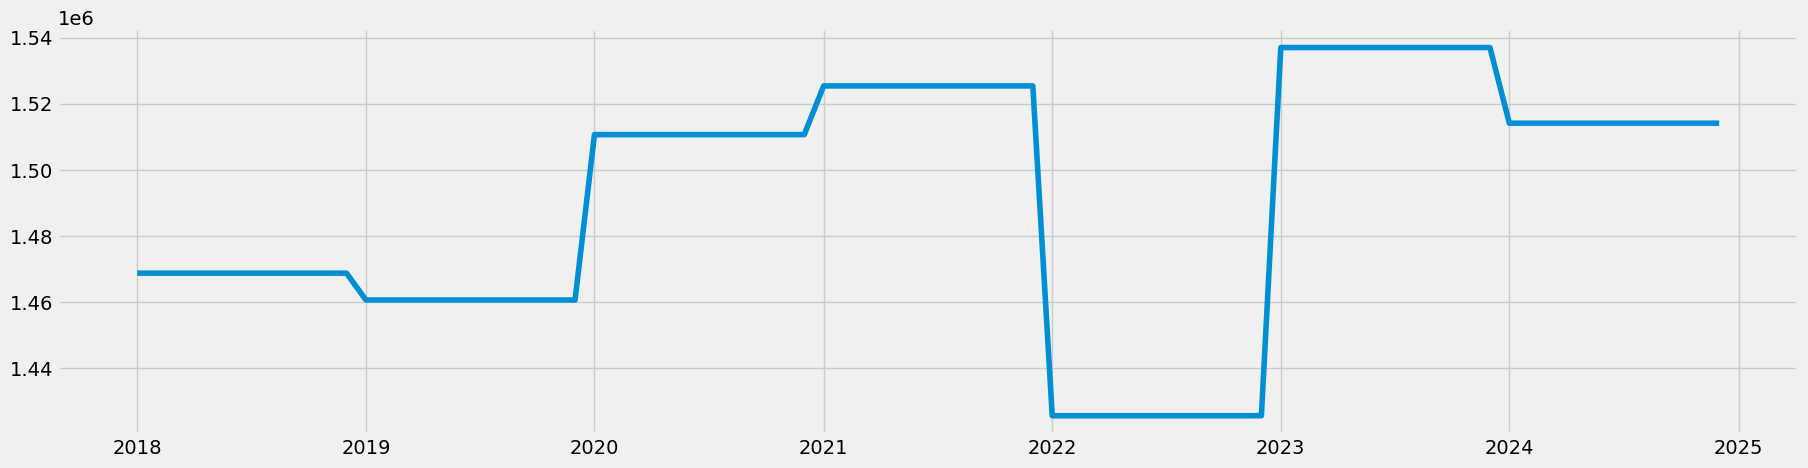

In [24]:
# Plot the data using matplotlib.

plt.figure(figsize=(20,5), dpi=100)
plt.plot(total_waste_by_month)

In [25]:
# Check for missing values 
total_waste_by_month.isnull().sum()

Monthly Waste (Tons)    0
dtype: int64

In [26]:
# Check for duplicates

dups = total_waste_by_month.duplicated()
dups.sum()



77

In [27]:
dups

Date
2018-01-01    False
2018-02-01     True
2018-03-01     True
2018-04-01     True
2018-05-01     True
              ...  
2024-08-01     True
2024-09-01     True
2024-10-01     True
2024-11-01     True
2024-12-01     True
Length: 84, dtype: bool

In [28]:
# Although there are duplicates found, it is becuase we have aggregated the values down to only month and total waste, 
# which can produce duplicated values for months, but they are still unique. 

## 04 Time-series analysis: decomposition

In [30]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(total_waste_by_month,model='additive',period=1)
rcParams['figure.figsize'] = 18, 7

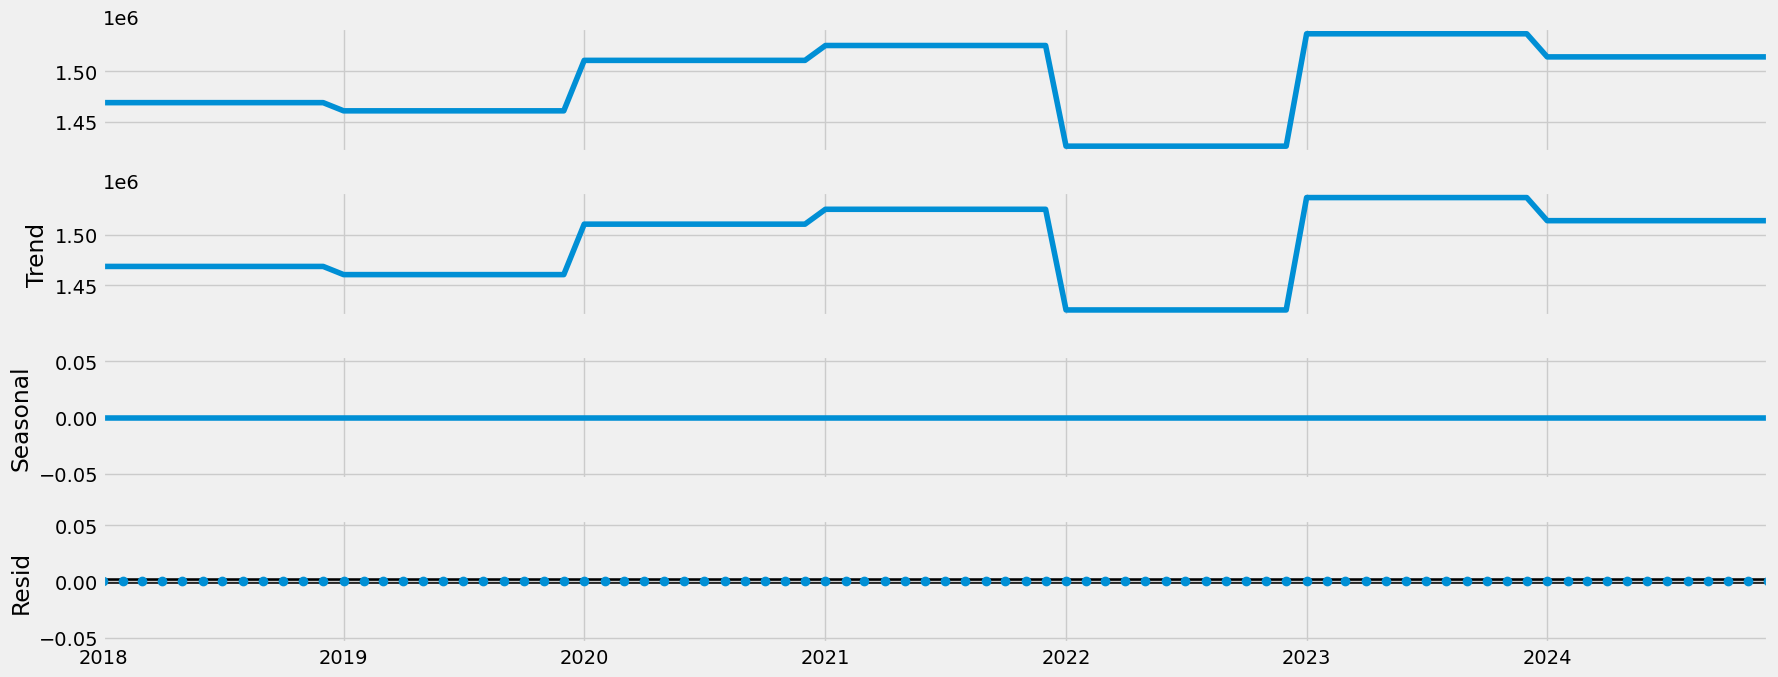

In [31]:
# Plot the separate components

decomposition.plot()
plt.show()

## Result Analysis: 
- The Level (first chart) and the Trend are pretty similar. Since the data does not have any noise, and does not need any smoothing, the trend level appears the same.
- Although data exists for 2022, there is a sharp dip during this year, most likely due to macro economic events or an error in data recording. From 2023, the trend stabilizes.
- The Seasonal chart indicates that there is no seasonality in this data. This is mainly due to the data wrangling where each year was equally divided into 12 months, resulting in 0 seasonality.
- The Residual chart indicates no noise in this time series. This is also due to the equal monthly split of the data.
- In conclusion, the time series set that was analysed is very limited and thus hard to interpret as it had only yearly data for 6 years (2018 - 2022). From the decomposition chart above, its clear that there is no seasonality and no trend, which suggests that this is most likely stationary data


## 05. Testing for stationarity

In [34]:
# Running the Dickey Fuller test

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(total_waste_by_month['Monthly Waste (Tons)'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.652551
p-value                         0.455710
Number of Lags Used            12.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


## Interpretation of Results: 
- What we were looking for here is to compare the test statistic to the critical value of the corresponding significance level.
- Here we have a Test Statistic of -1.65 and a significance value of 0.45  
- Since the test statistic is larger than the critical value, we can't reject the null hypothesis and this suggests non-stationary data. 

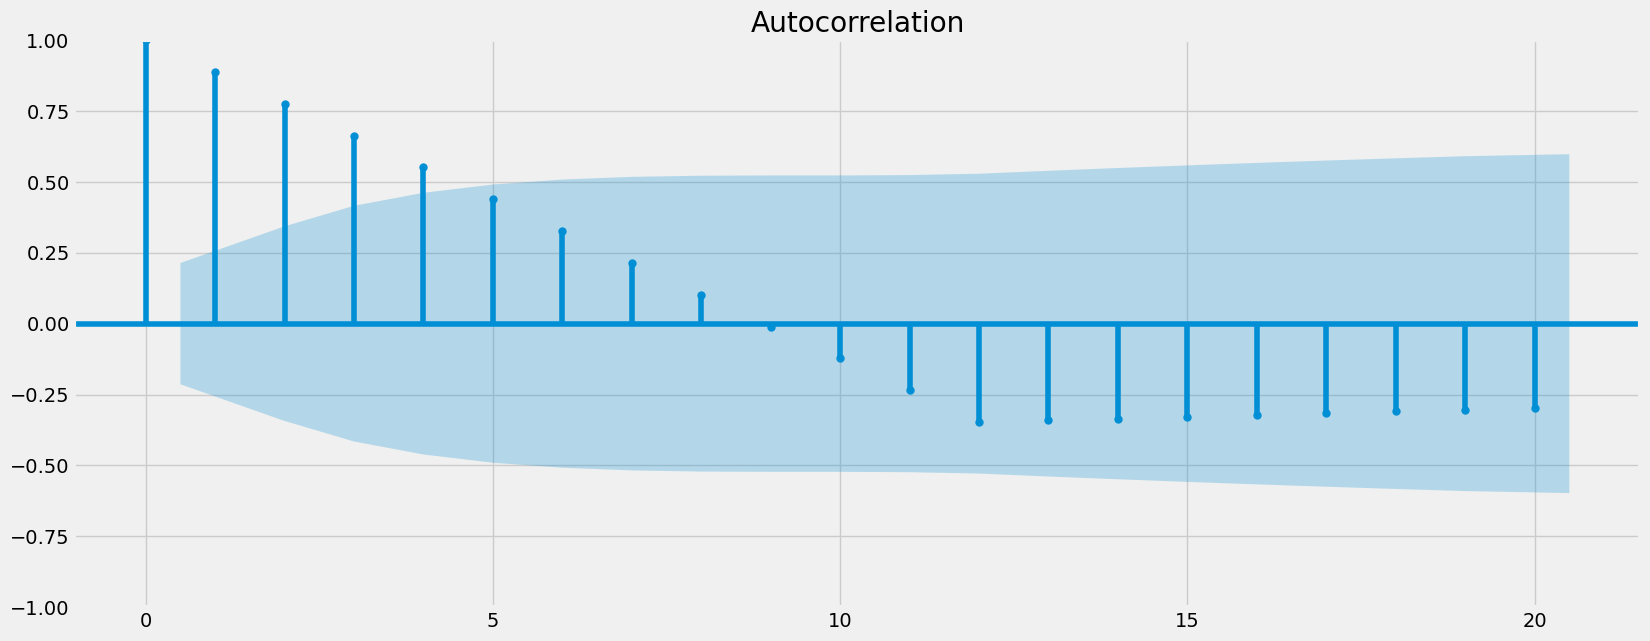

In [36]:
# testing for autocorrelations

plot_acf(total_waste_by_month)
plt.show()

## Findings: 
- In this chart we can see 5 autocorrelated terms (blue lines above the confidence interval). This means that little autocorrelation exists, and the data is stationary, which does not correspond with the Dickey Fulle test above. 

## 06. Stationarizing the data

In [39]:
# To stationarize the data we are using Differencing. 
# Here we are transforming the time series into a new time series, by subtracting the lag of a data point from the current data point)

data_diff = total_waste_by_month - total_waste_by_month.shift(1)

In [40]:
# Now removing the missing values to be able to run the Dicky 

data_diff.dropna(inplace = True)

In [41]:
data_diff.head()

,Monthly Waste (Tons)
Date,
2018-02-01,0.0
2018-03-01,0.0
2018-04-01,0.0
2018-05-01,0.0
2018-06-01,0.0


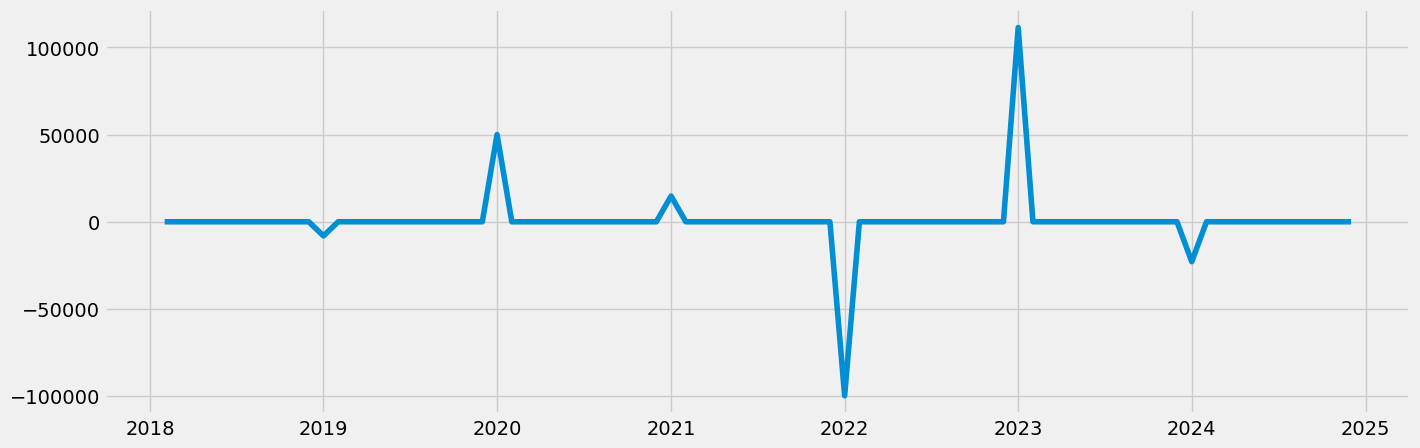

In [42]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [43]:
#  Runniong the Dickey Fuller test again

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.365859
p-value                         0.000341
Number of Lags Used            11.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


## The test statistic is now smaller than the critical value on 1, 5 and 10% and a satisfactory p-vlaue of smaller than 0.05. This means the data is now Stationary. 

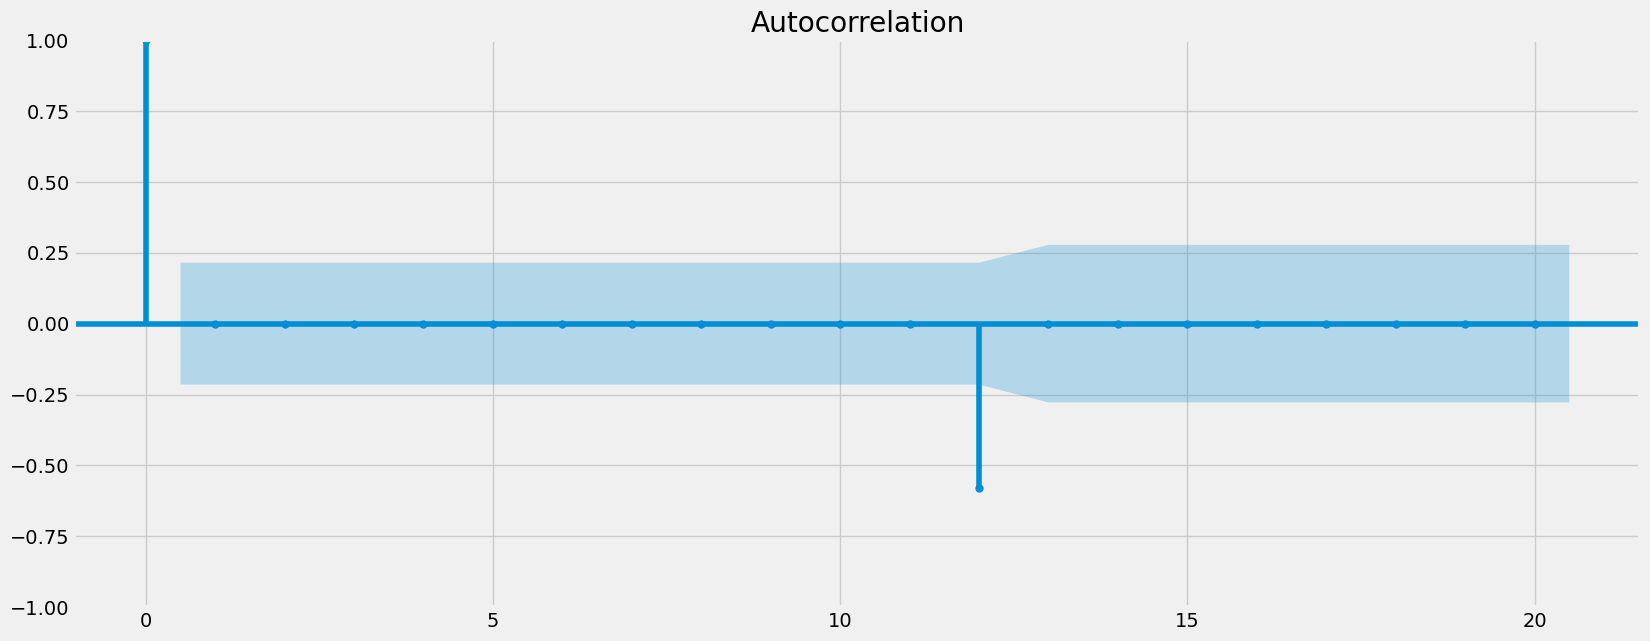

In [45]:
# Lastly testing for autocorrelations again

plot_acf(data_diff)
plt.show()

In [46]:
# Judging by the chart, the data could now be OVERdifferenced as we have only 1 point above the confidence interval